# NYC Taxi Prediction using Linear Regression  
**Table of Contents**  
- [1. Introduction](#1.-Introduction)  
- [2. Preprocessing Data](#2.-Preprocessing-Data)    
- [3. Data and Methods](#3.-Data-and-Methods)  
- [4. Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)  
    - [4.1. How does taxi usage change over a month](#4.1.-What-is-the-most-common-chest-pain-type-by-age-group?)
    - [4.2 Which month has the highest number of taxi trips of the year?](#4.2.-Explore-the-effect-of-diabetes-on-heart-disease)
    - [4.3. Which day of the week is the most popular for taxi trips?](#4.3.-Explore-the-effect-of-hypertension-on-heart-disease)
    - [4.4. Which quarter is the most popular for taxi trips ?]()
    - [4.5. Distribution of trips, distance and fare amount by hour of the day]()
    - [4.6. The affect of categorical on total amount]()
- [5. Model Building](#5.-Model-Building)
    - [5.1 Feature Engineering](#5.1-Feature-Engineering)
    - [5.2 Model Training](#5.2-Model-Training)


## [1. Introduction](#1-introduction)  
In today's fast-paced world, taking a taxi has become an indispensable part of daily life for many. However, one of the most significant inconveniences passengers face is the inability to accurately estimate the cost of a ride before it begins. This not only creates inconvenience but can also lead to feelings of uncertainty and mistrust towards the service. Understanding this need, we have leveraged technology and the data we have collected to develop a solution that provides customers with more accurate and transparent fare estimates.

## [2. Preprocessing Data](#2.-Preprocessing-Data)

In [473]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings 
from typing import Dict, Tuple
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
warnings.filterwarnings('ignore')
pd.set_option('display.colheader_justify', 'center')

Load the data

In [474]:
def load_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

PATH = r'2017_Yellow_Taxi_Trip_Data.csv'
data = load_data(PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

Changing the columns name

In [475]:
def drop_column_name(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns='Unnamed: 0')


Changing the data types

In [476]:
def changing_data_types(df: pd.DataFrame) -> pd.DataFrame:
    return df.astype({
        'tpep_pickup_datetime': 'datetime64[ns]',
        'tpep_dropoff_datetime': 'datetime64[ns]',
        'VendorID': 'category',
        'RatecodeID': 'category',
        'store_and_fwd_flag': 'category',
        'PULocationID': 'category',
        'DOLocationID': 'category',
        'payment_type': 'category'
    })

In [477]:
def change_categorical_data(df: pd.DataFrame) -> pd.DataFrame:

    df.VendorID = df.VendorID.map({
        1: 'Creative Mobile Technologies',
        2: 'VeriFone Inc'
    })

    df.RatecodeID = df.RatecodeID.map({
        1: 'Standard rate',
        2: 'JFK', 
        3: 'Newark',
        4: 'Nassau of Westchester',
        5: 'Negotiated fare',
        6: 'Group ride'
    })

    df.store_and_fwd_flag = df.store_and_fwd_flag.map({
        'Y': 'Store and forward trip',
        'N': 'Not a store and forward trip'
    })

    df.payment_type = df.payment_type.map({
        0: 'Flex Fare trip',
        1: 'Credit Card',
        2: 'Cash',
        3: 'No charge',
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided Trip'
    })

    return df

In [478]:
# def identifying_threshold(sr: pd.Series) -> Tuple[float, float]:
#     q1 = sr.quantile(0.25)
#     q3 = sr.quantile(0.75)
#     iqr = q3 - q1
#     upper = q3 + 3 * iqr
#     lower = q1 - 1.5 * iqr

#     return (lower, upper)

# def removing_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
#     lower, upper = identifying_threshold(df[col])
    
#     return df[((df[col] >= lower) & (df[col] <= upper))]



Number of outliers

In [479]:
def number_of_outliers(df: pd.DataFrame) -> pd.DataFrame:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() \
        .to_frame('number_of_outliers').style.background_gradient() \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 2. Number of outliers')


number_of_outliers(data.select_dtypes(include='number'),)

,number_of_outliers
Unnamed: 0,0
VendorID,0
passenger_count,2291
trip_distance,2527
RatecodeID,629
PULocationID,0
DOLocationID,0
payment_type,46
fare_amount,2064
extra,103


In [480]:
def preprocessing_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()
    df = drop_column_name(df)

    df = changing_data_types(df)
    df = change_categorical_data(df)

    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    return df 

data = preprocessing_data(data)
data = pd.concat([data.iloc[:, :-2], data['duration'], data['total_amount']], axis=1)
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,duration,total_amount
0,VeriFone Inc,2017-03-25 08:55:00,2017-03-25 09:09:00,6,3.34,Standard rate,Not a store and forward trip,100,231,Credit Card,13.0,0.0,0.5,2.76,0.00,0.3,14.0,16.56
1,Creative Mobile Technologies,2017-04-11 14:53:00,2017-04-11 15:19:00,1,1.80,Standard rate,Not a store and forward trip,186,43,Credit Card,16.0,0.0,0.5,4.00,0.00,0.3,26.0,20.80
2,Creative Mobile Technologies,2017-12-15 07:26:00,2017-12-15 07:34:00,1,1.00,Standard rate,Not a store and forward trip,262,236,Credit Card,6.5,0.0,0.5,1.45,0.00,0.3,8.0,8.75
3,VeriFone Inc,2017-05-07 13:17:00,2017-05-07 13:48:00,1,3.70,Standard rate,Not a store and forward trip,188,97,Credit Card,20.5,0.0,0.5,6.39,0.00,0.3,31.0,27.69
4,VeriFone Inc,2017-04-15 23:32:00,2017-04-15 23:49:00,1,4.37,Standard rate,Not a store and forward trip,4,112,Cash,16.5,0.5,0.5,0.00,0.00,0.3,17.0,17.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22694,VeriFone Inc,2017-02-24 17:37:00,2017-02-24 17:40:00,3,0.61,Standard rate,Not a store and forward trip,48,186,Cash,4.0,1.0,0.5,0.00,0.00,0.3,3.0,5.80
22695,VeriFone Inc,2017-08-06 16:43:00,2017-08-06 17:24:00,1,16.71,JFK,Not a store and forward trip,132,164,Credit Card,52.0,0.0,0.5,14.64,5.76,0.3,41.0,73.20
22696,VeriFone Inc,2017-09-04 14:54:00,2017-09-04 14:58:00,1,0.42,Standard rate,Not a store and forward trip,107,234,Cash,4.5,0.0,0.5,0.00,0.00,0.3,4.0,5.30
22697,VeriFone Inc,2017-07-15 12:56:00,2017-07-15 13:08:00,1,2.36,Standard rate,Not a store and forward trip,68,144,Credit Card,10.5,0.0,0.5,1.70,0.00,0.3,12.0,13.00


## [3. Data And Methods](#3-data-and-methods)

**Information about the dataset**  
- 'VendorID' - A code indicating the TPEP provider that provided the record. (1='Creative Mobile Technologies, LLC', 2='VeriFone Inc')  
- 'tpep_pickup_datetime' - The date and time when the meter was engaged.  
- 'tpep_dropoff_datetime' - The date and time when the meter was disengaged. 
- 'passenger_count' - The number of passengers in the vehicle.  
- 'trip_distance' - The elapsed trip distance in miles reported by the taximeter.  
- 'RatecodeID' - The final rate code in effect at the end of the trip. (1='Standard rate', 2='JFK', 3='Newark', 4='Nassau of Westchester', 5='Negotiated fare', 6='Group ride', 99='NULL/unknown')  
- 'store_and_fwd_flag' - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. (Y='store and forward trip', N='not a store and forward trip')  
- 'PULocationID' - TLC Taxi Zone in which the taximeter was engaged  
- 'DOLocationID' - TLC Taxi Zone in which the taximeter was disengaged  
- 'payment_type' - A numeric code signifying how the passenger paid for the trip. (0= 'Flex Fare trip', 1= 'Credit card', 2= 'Cash', 3= 'No charge', 4= 'Dispute', 5= 'Unknown', 6= 'Voided trip')  
- 'fare_amount' - The time-and-distance fare calculated by the meter. For additional information on the following columns
- 'extra' - Miscellaneous extras and surcharges.  
- 'mta_tax' - Tax that is automatically triggered based on the metered rate in use.  
- 'tip_amount' - Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.  
- 'tolls_amount' - Total amount of all tolls paid in trip.  
- 'improvement_surcharge' - Improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.  
- 'total_amount' - The total amount charged to passengers. Does not include cash tips. 

**Remark On the Dataset**: the dataset contain 22699 rows and 17 columns, with no missing values or duplicate rows. All the numeric columns is positive number. To prevent the model's operation is unstable, we remove outlier.  

**Methods**: Our exploratory data analysis included various methodologies such as: data cleaning, data wrangling, data visualization, statistical analysis. To clean data, we use pandas, numpy to handle missing values, remove outliers and transform variable necessary. 

In [481]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,duration,total_amount
0,VeriFone Inc,2017-03-25 08:55:00,2017-03-25 09:09:00,6,3.34,Standard rate,Not a store and forward trip,100,231,Credit Card,13.0,0.0,0.5,2.76,0.0,0.3,14.0,16.56
1,Creative Mobile Technologies,2017-04-11 14:53:00,2017-04-11 15:19:00,1,1.80,Standard rate,Not a store and forward trip,186,43,Credit Card,16.0,0.0,0.5,4.00,0.0,0.3,26.0,20.80
2,Creative Mobile Technologies,2017-12-15 07:26:00,2017-12-15 07:34:00,1,1.00,Standard rate,Not a store and forward trip,262,236,Credit Card,6.5,0.0,0.5,1.45,0.0,0.3,8.0,8.75
3,VeriFone Inc,2017-05-07 13:17:00,2017-05-07 13:48:00,1,3.70,Standard rate,Not a store and forward trip,188,97,Credit Card,20.5,0.0,0.5,6.39,0.0,0.3,31.0,27.69
4,VeriFone Inc,2017-04-15 23:32:00,2017-04-15 23:49:00,1,4.37,Standard rate,Not a store and forward trip,4,112,Cash,16.5,0.5,0.5,0.00,0.0,0.3,17.0,17.80


In [482]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               22699 non-null  category      
 1   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 3   passenger_count        22699 non-null  int64         
 4   trip_distance          22699 non-null  float64       
 5   RatecodeID             22698 non-null  object        
 6   store_and_fwd_flag     22699 non-null  category      
 7   PULocationID           22699 non-null  category      
 8   DOLocationID           22699 non-null  category      
 9   payment_type           22699 non-null  category      
 10  fare_amount            22699 non-null  float64       
 11  extra                  22699 non-null  float64       
 12  mta_tax                22699 non-null  float64       
 13  t

## [4. Exploratory Data Analysis](#4-exploratory-data-analysis)

We use box plot to provide some indication of the data's symmetry and skewness

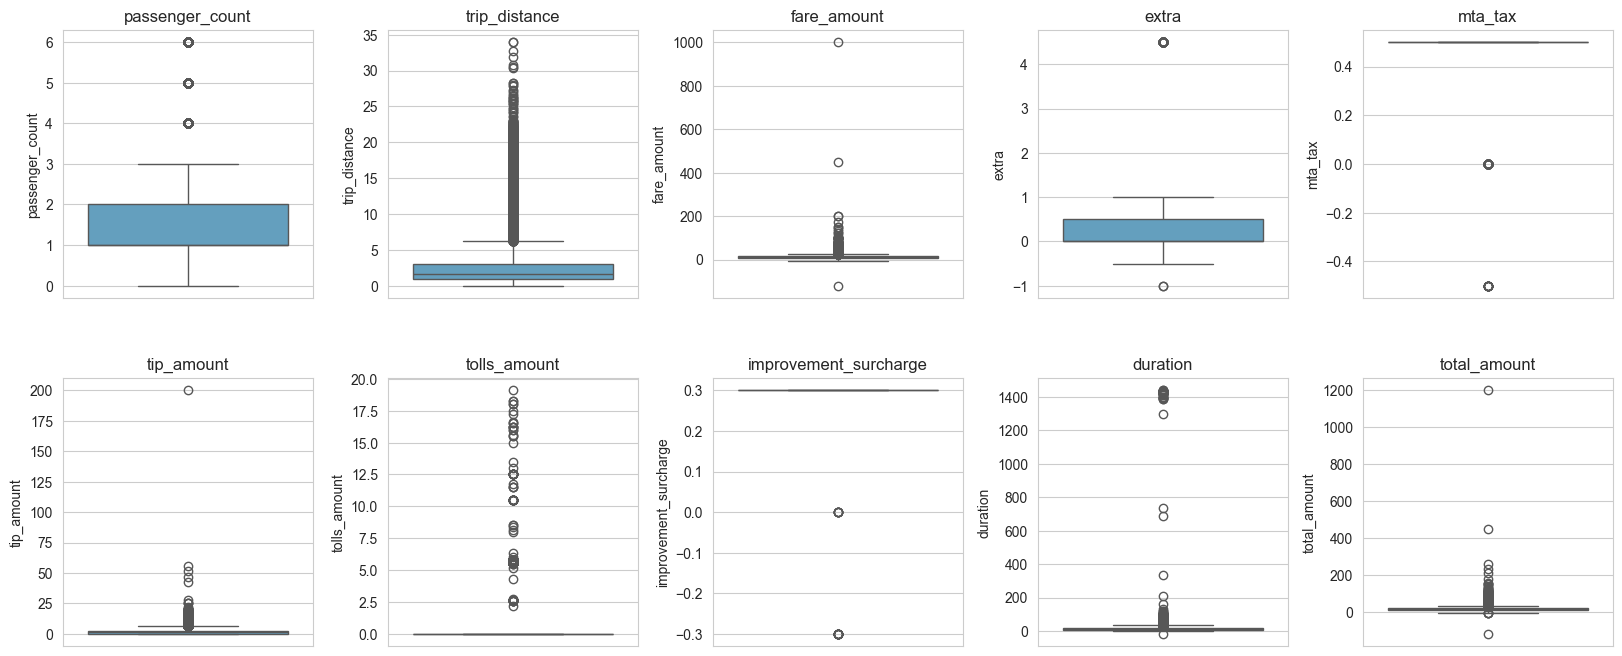

In [483]:
def plot_statistics_numerical_columns(df: pd.DataFrame) -> None:
    sns.set_palette('icefire')
    fig, axes = plt.subplots(2, 5, figsize=(20,8))

    for col, ax in zip(df.columns, axes.flatten()):
        sns.boxplot(df[col], ax=ax, showfliers=True)
        ax.set_xlabel('')
        ax.set_title(col)

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

plot_statistics_numerical_columns(data.select_dtypes(include='number'))

From boxplot, we can observe that 'duration', 'total_amount', 'improvement_surcharge', 'fare_amount' and 'mta_tax' seem contain negative values. That is not correct, so we will impute those values by 0. At the same time, the values ​​are too large will be imputed.

Boxplot after handle outliers


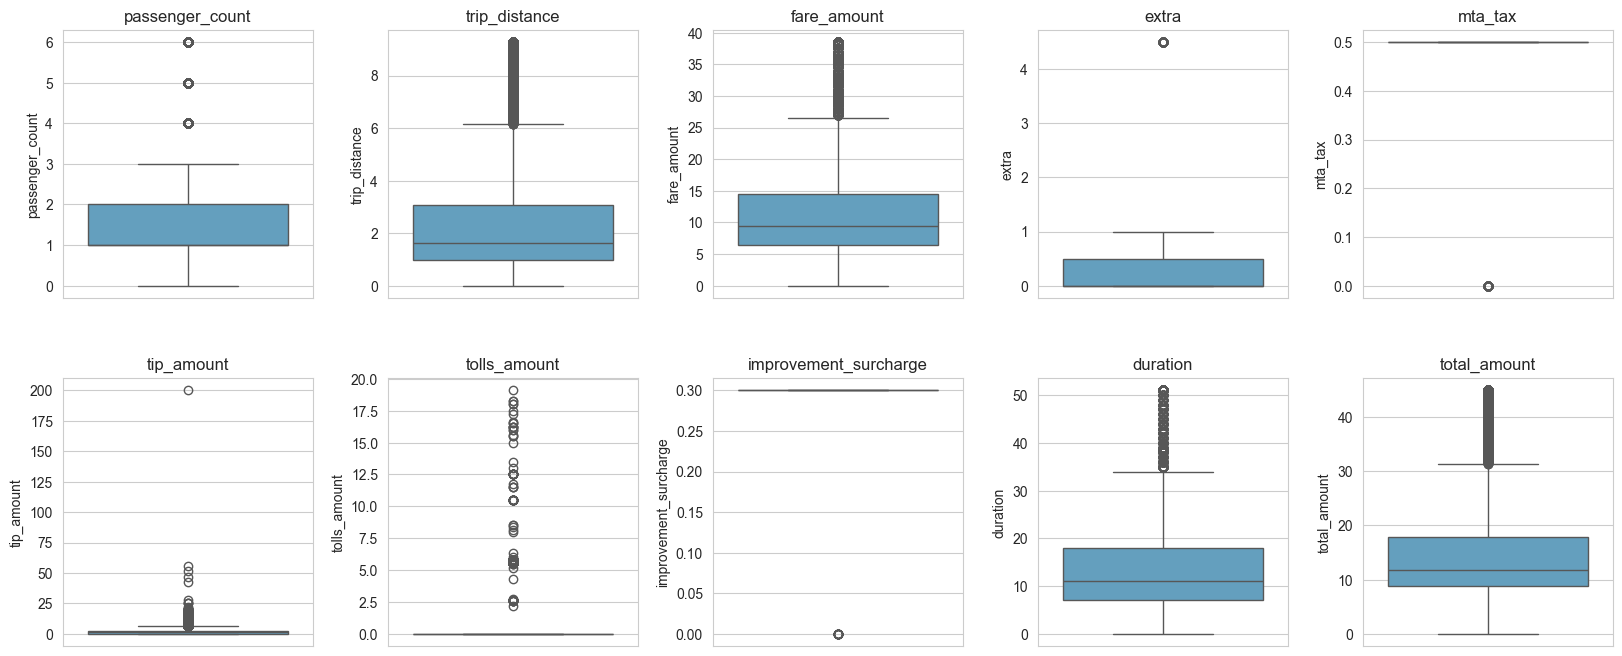

In [484]:
def outlier_imputer(df, column_list, iqr_factor):
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold

    return df
data.loc[data['improvement_surcharge'] < 0, 'improvement_surcharge'] = 0
data.loc[data['extra'] < 0, 'extra'] = 0
data = outlier_imputer(data, ['fare_amount', 'total_amount', 'duration', 'mta_tax', 'trip_distance'], 3)
print('Boxplot after handle outliers')
plot_statistics_numerical_columns(data.select_dtypes(include='number'))

In [485]:
num = data.select_dtypes(include='number')
cat = data.select_dtypes(exclude='number')

Plot distribution of numerical column

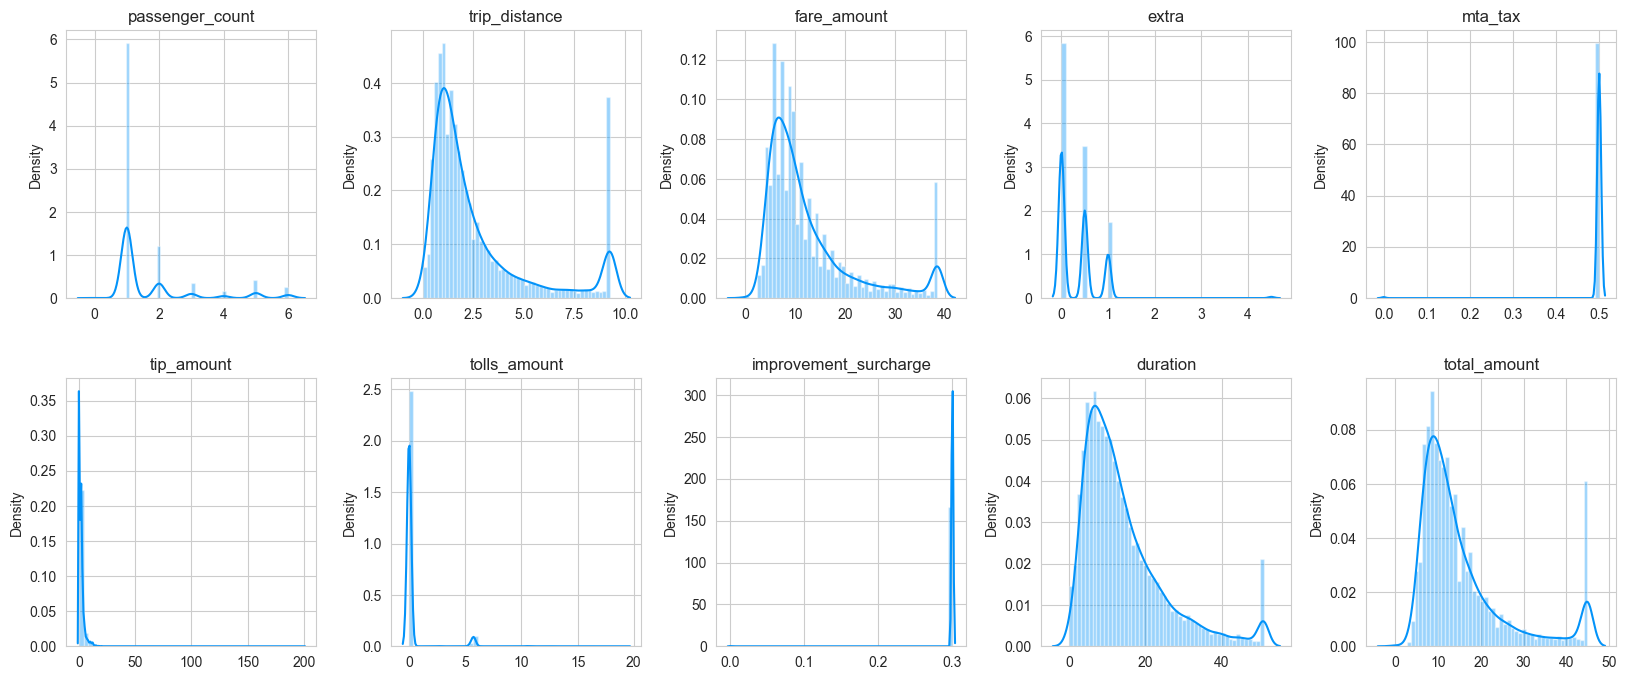

In [486]:
def plot_distribution_numerical_column(df: pd.DataFrame) -> None:
    sns.set_palette('terrain', 6)
    fig, axes = plt.subplots(2, 5, figsize=(20,8))

    for col, ax in zip(df.columns, axes.flatten()):
        sns.distplot(df[col], ax=ax)
        ax.set_xlabel('')
        ax.set_title(col)

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

plot_distribution_numerical_column(num)

Plot Basic Statistics 

In [487]:
def basic_statistics(df: pd.DataFrame):
    return df.describe().T.style.background_gradient() \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 1. Basic statistics of the numerical features')
basic_statistics(num)


,count,mean,std,min,25%,50%,75%,max
passenger_count,22699.000000,1.642319,1.285231,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,22699.000000,2.578687,2.465908,0.000000,0.990000,1.610000,3.060000,9.270000
fare_amount,22699.000000,12.377925,8.739028,0.000000,6.500000,9.500000,14.500000,38.500000
extra,22699.000000,0.333517,0.462744,0.000000,0.000000,0.000000,0.500000,4.500000
mta_tax,22699.000000,0.497731,0.033605,0.000000,0.500000,0.500000,0.500000,0.500000
tip_amount,22699.000000,1.835781,2.800626,0.000000,0.000000,1.350000,2.450000,200.000000
tolls_amount,22699.000000,0.312542,1.399212,0.000000,0.000000,0.000000,0.000000,19.100000
improvement_surcharge,22699.000000,0.299736,0.008901,0.000000,0.300000,0.300000,0.300000,0.300000
duration,22699.000000,14.167188,10.684253,0.000000,7.000000,11.000000,18.000000,51.000000
total_amount,22699.000000,15.341609,10.237528,0.000000,8.750000,11.800000,17.800000,44.950000


Plot the correlation between variable

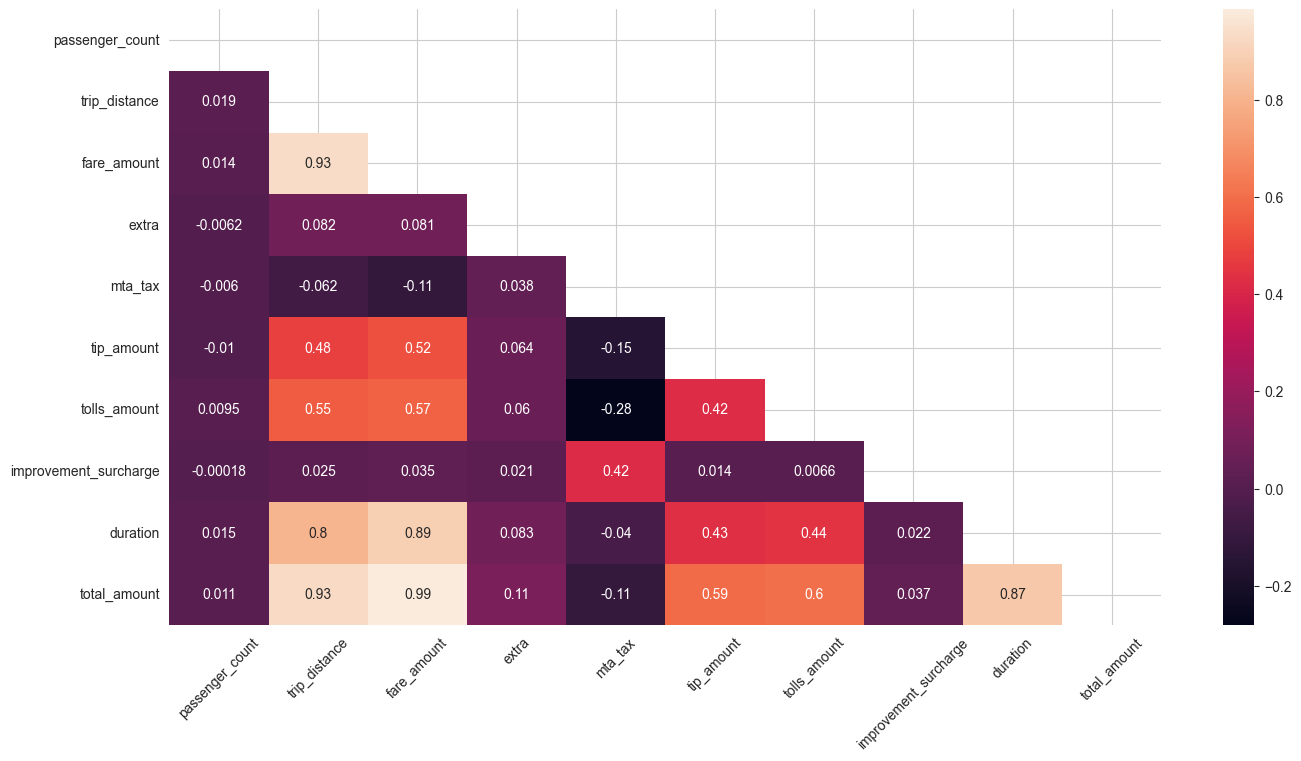

In [488]:
# Plot correlation
def plot_corr(df: pd.DataFrame) -> None:
    sns.set_palette('viridis')
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(16,8))
    sns.heatmap(corr, mask=mask, annot=True)
    plt.xticks(rotation=45)

plot_corr(num)

In the correlation plot, it's evident that 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'duration' exhibit strong correlations with 'total_amount.' Let's delve deeper into this relationship in the subsequent section.

VendorID
RatecodeID
store_and_fwd_flag
payment_type


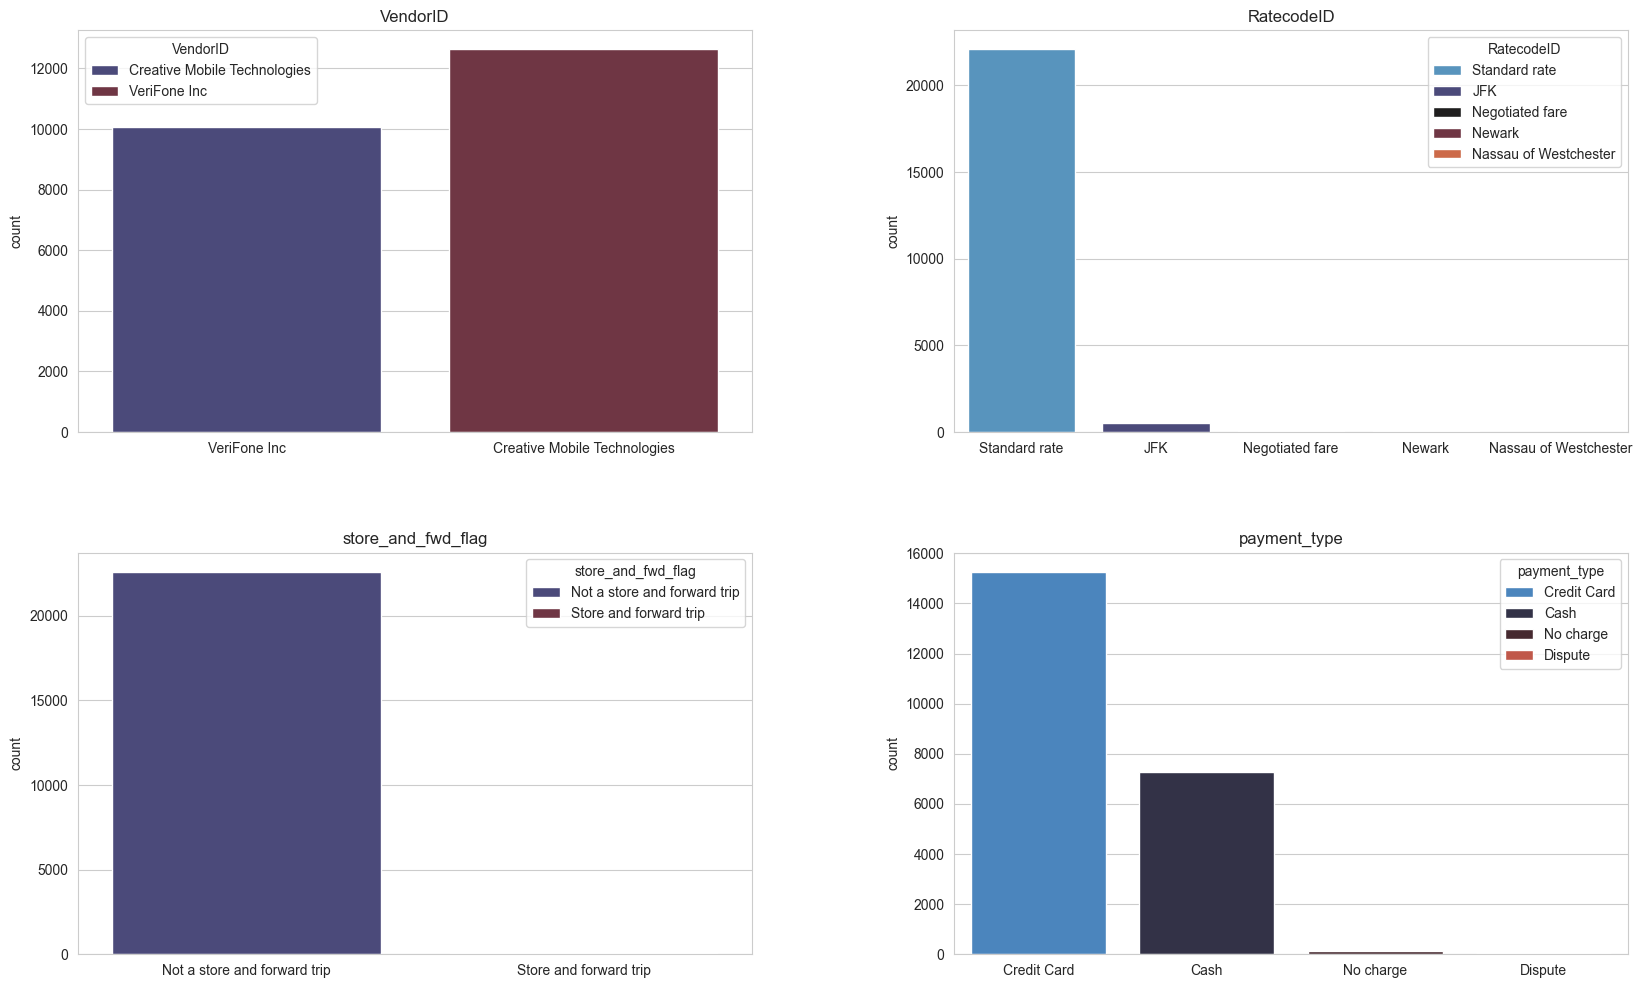

In [489]:
def plot_category(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(2, 2, figsize=(20,12))

    for col, ax in zip(df.columns, axes.flatten()):
        print(col)
        sns.countplot(x=df[col],
                      palette='icefire',
                      hue=df[col],
                      legend=True, ax=ax)
        ax.set_xlabel('')
        ax.set_title(col)
        ax.set_xticklabels(df[col].unique())

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
# cat_c = cat.copy()
# cat_c.drop(columns=['tpep_pickup_datetime', 'tpep_pickup_datetime', 'PULocationID', 'DOLocationID'])
plot_category(cat.copy().drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']))

### [4.1. How does taxi usage change over a month]()

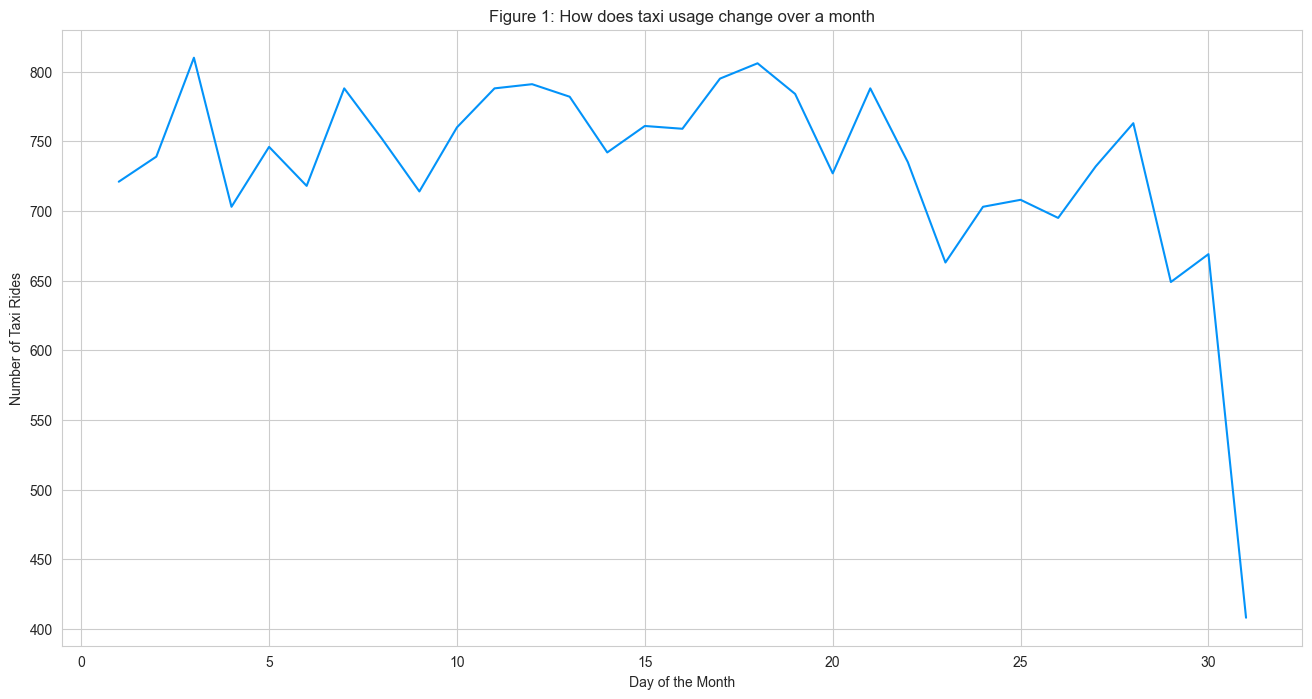

In [490]:
def plot_taxi_usage_over_month(df: pd.DataFrame) -> None:
    # Set seaborn palette and figure size
    sns.set_palette('terrain')
    plt.figure(figsize=(16, 8))
    
    # Group data by day of the month and count the number of taxi rides for each day
    taxi_usage = df['tpep_pickup_datetime'].dt.day.value_counts().sort_index()
    
    # Plotting
    sns.lineplot(x=taxi_usage.index, y=taxi_usage.values)
    plt.title('Figure 1: How does taxi usage change over a month')
    plt.xlabel('Day of the Month')
    plt.ylabel('Number of Taxi Rides')

plot_taxi_usage_over_month(cat)

We observe a relatively steady pattern of taxi usage throughout each day of the month. However, there is a noticeable decline in the number of trips towards the end of the month. Do they seem to have used up all their transportation budget at the beginning and middle of the month?

### [4.2 Which month has the highest number of taxi trips of the year?]()

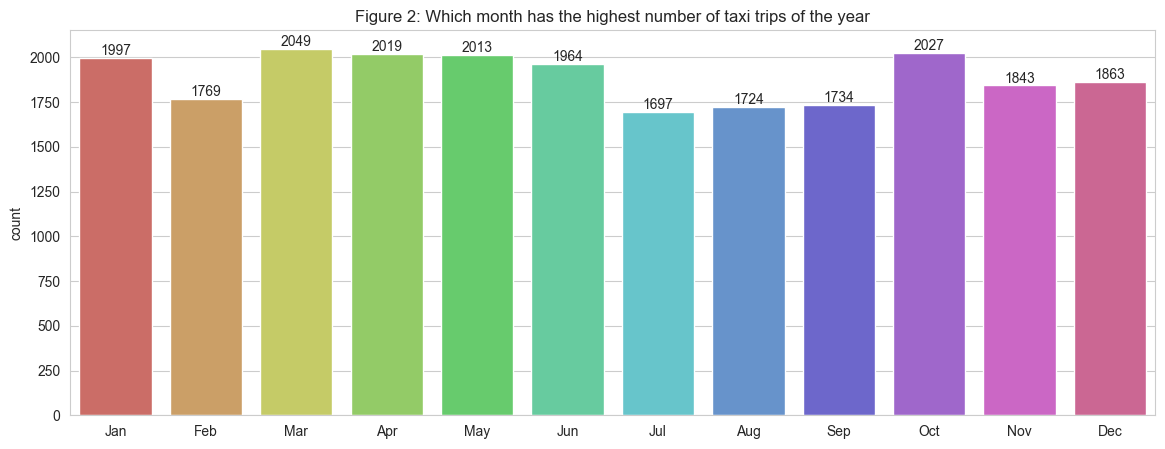

In [491]:
def plot_taxi_usage_over_year(df: pd.DataFrame) -> None:
    taxi_usage = df['tpep_pickup_datetime'].dt.month
    plt.figure(figsize=(14,5))
    ax = sns.countplot(x=taxi_usage, palette='hls')
    plt.xticks(range(0, 12),
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')  

    plt.xlabel('')
    plt.title('Figure 2: Which month has the highest number of taxi trips of the year')
     
    

print()
plot_taxi_usage_over_year(cat)


### [4.3. Which day of the week is the most popular for taxi trips?]()

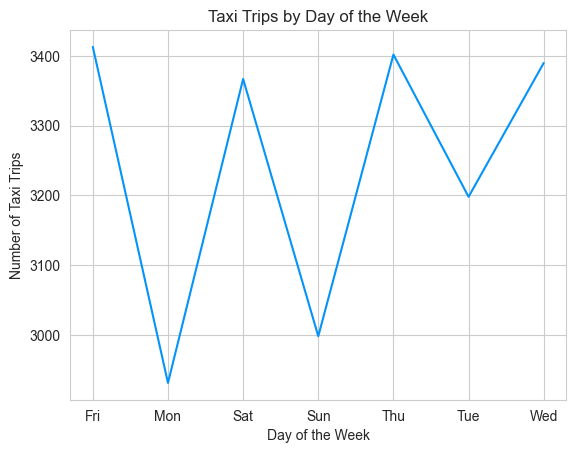

In [492]:
def plot_taxi_trip_by_dow(df: pd.DataFrame) -> None:
    taxi_usage = df['tpep_pickup_datetime'].dt.strftime('%a')
    sns.set_style('whitegrid')
    taxi_usage_counts = taxi_usage.value_counts().sort_index()
    
    # Plotting
    sns.lineplot(x=taxi_usage_counts.index, y=taxi_usage_counts.values, palette='magma')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Taxi Trips')
    plt.title('Taxi Trips by Day of the Week')

plot_taxi_trip_by_dow(cat)

### [4.4. Which quarter is the most popular for taxi trips ?]()

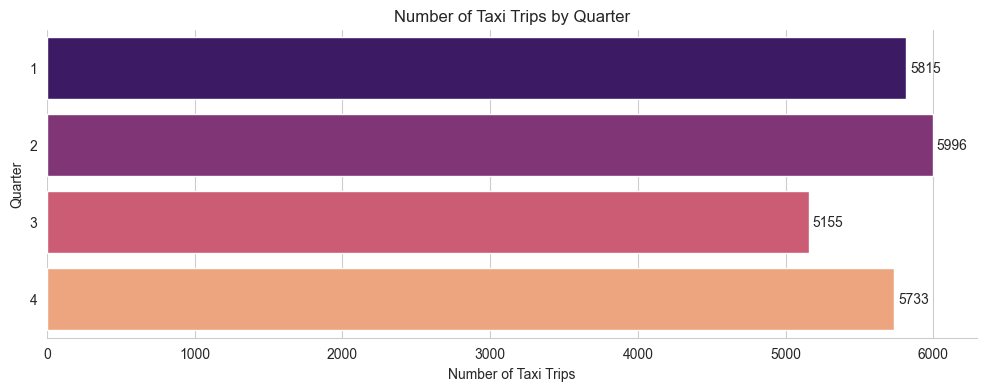

In [493]:
def plot_most_busy_quarter(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(12,4))
    quarter_counts = df['tpep_pickup_datetime'].dt.quarter.value_counts().sort_index()
    sns.barplot(y=quarter_counts.index,
                x=quarter_counts.values,
                palette='magma',
                orient='h',
                ax=ax)

    for bar in ax.patches:
        width = bar.get_width()
        x_ = width
        y_ = bar.get_y() + bar.get_height() / 2
        label = f"{width:.0f}"
        ax.annotate(label, (x_, y_),
                    ha='left', va='center',
                    xytext=(3, 0), fontsize=10,
                    textcoords='offset points')

    plt.ylabel('Quarter')
    plt.xlabel('Number of Taxi Trips')
    plt.title('Number of Taxi Trips by Quarter')
    sns.despine(left=True)

    plt.show()

plot_most_busy_quarter(cat)

### [4.5. Distribution of trips, distance and fare amount by hour of the day]()

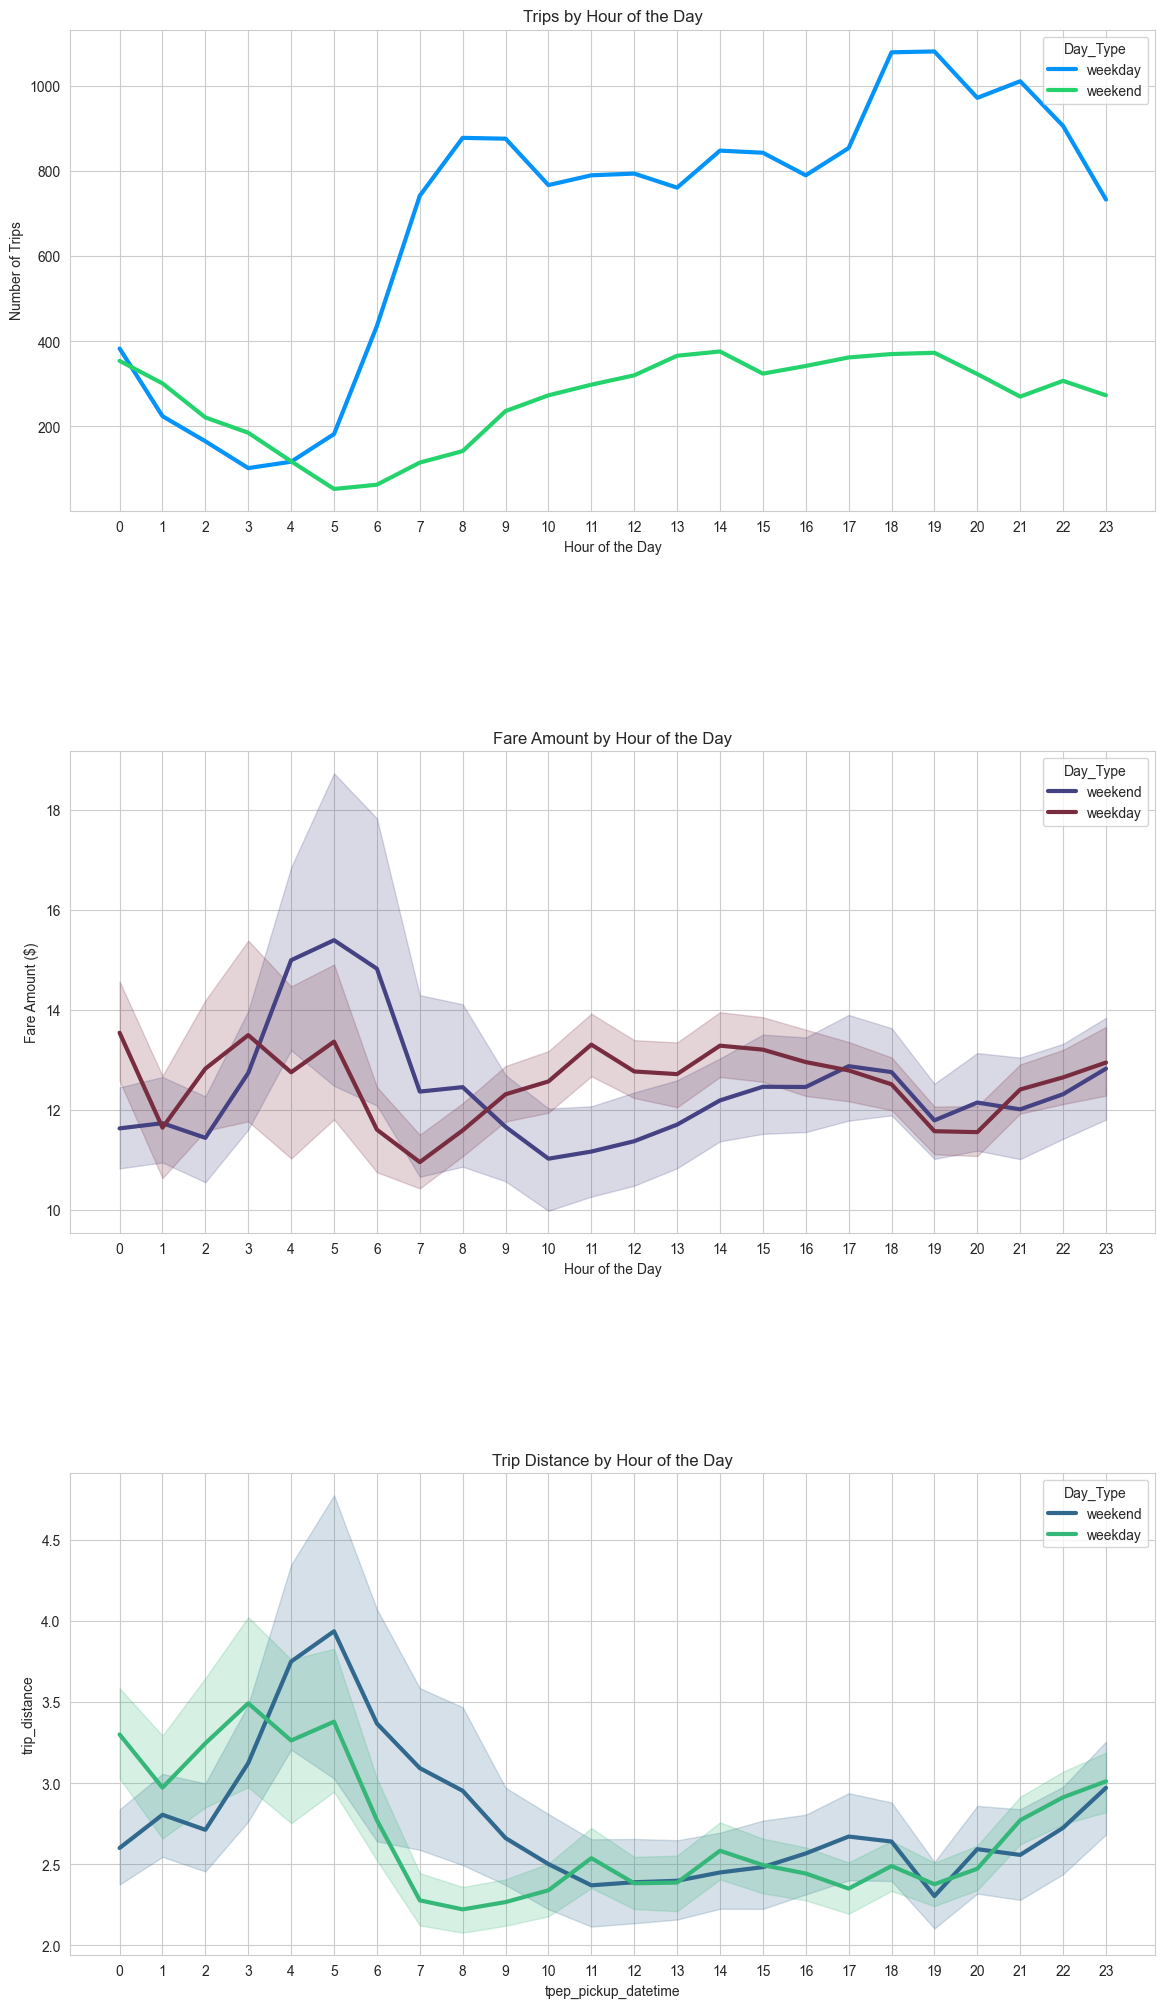

In [494]:
def plot_distribution_by_hour(df: pd.DataFrame) -> None:

    df['Day_Type'] = df['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')

    # Set up the figure and subplots
    fig, axs = plt.subplots(3, 1, figsize=(14, 25))  # Share x-axis across subplots
    fig.subplots_adjust(hspace=0.5)  # Adjust the space between plots
    sns.set_style('whitegrid')


    #  trips by hour of the day
    hourly_trips = df.groupby([df['tpep_pickup_datetime'].dt.hour, 'Day_Type']).size().reset_index(name='Number of Trips')
    sns.lineplot(data=hourly_trips, 
             x='tpep_pickup_datetime',  # This should be the hour after groupby
             y='Number of Trips', 
             hue='Day_Type',
             ax=axs[0], 
             linewidth=3)
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Number of Trips')
    axs[0].set_title('Trips by Hour of the Day')
    axs[0].set(xticks=range(0, 24), xticklabels=range(0, 24))


    #  fare amount by hour of the day
    sns.lineplot(x=df['tpep_pickup_datetime'].dt.hour,
                y=df['fare_amount'],
                palette='icefire',
                hue=df['Day_Type'],
                linewidth=3,
                ax=axs[1]
                )
    axs[1].set_xlabel('Hour of the Day')
    axs[1].set_ylabel('Fare Amount ($)')
    axs[1].set_title('Fare Amount by Hour of the Day')
    axs[1].set(xticks=range(0, 24), xticklabels=range(0, 24))

    sns.lineplot(data=df, 
                x=df['tpep_pickup_datetime'].dt.hour,
                y='trip_distance',
                hue='Day_Type',
                linewidth=3,
                palette='viridis')  
    axs[2].set_title('Trip Distance by Hour of the Day')
    axs[2].set(xticks=range(0, 24), xticklabels=range(0, 24))  # Setting x-ticks properly

    plt.show()

plot_distribution_by_hour(pd.concat([num, cat], axis=1))

### [4.6. The affect of categorical on total amount]()

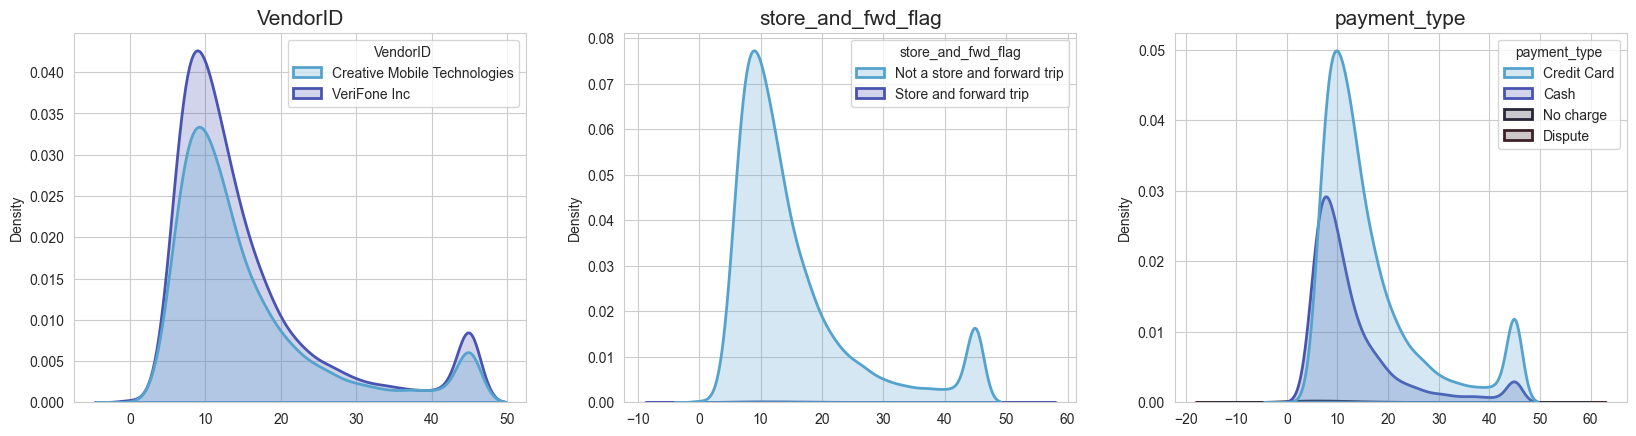

In [495]:
# Plot the distribution of the numerical features by heart disease
def plot_distribution_by_cat(df: pd.DataFrame) -> None:
    sns.set_palette('icefire')
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    df.drop(columns='RatecodeID', inplace=True)

    for ax, col in zip(axes.flatten(), df.columns.delete(-1)):
        sns.kdeplot(data=df, x='total_amount',
                    hue=col,
                    ax=ax,
                    linewidth=2,
                    fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.tight_layout(pad=3.0)

    plt.show()


plot_distribution_by_cat(pd.concat([cat.copy().drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID']), num['total_amount']], axis=1))

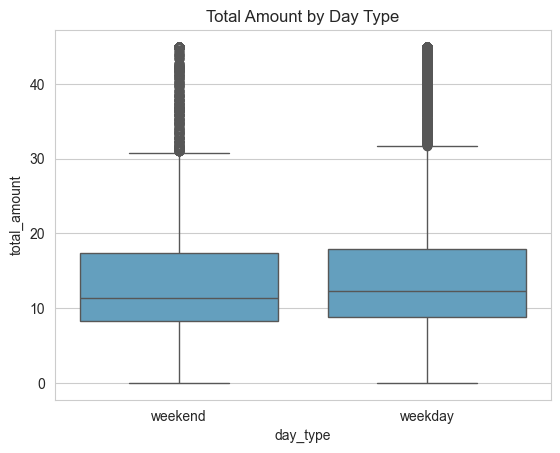

In [496]:
def plot_amount_by_day_type(df: pd.DataFrame) -> None:
    df['day_type'] = df['tpep_pickup_datetime'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
    sns.boxplot(data=df, x='day_type', y='total_amount')
    plt.title('Total Amount by Day Type')
    plt.show()
plot_amount_by_day_type(pd.concat([num, cat], axis=1))

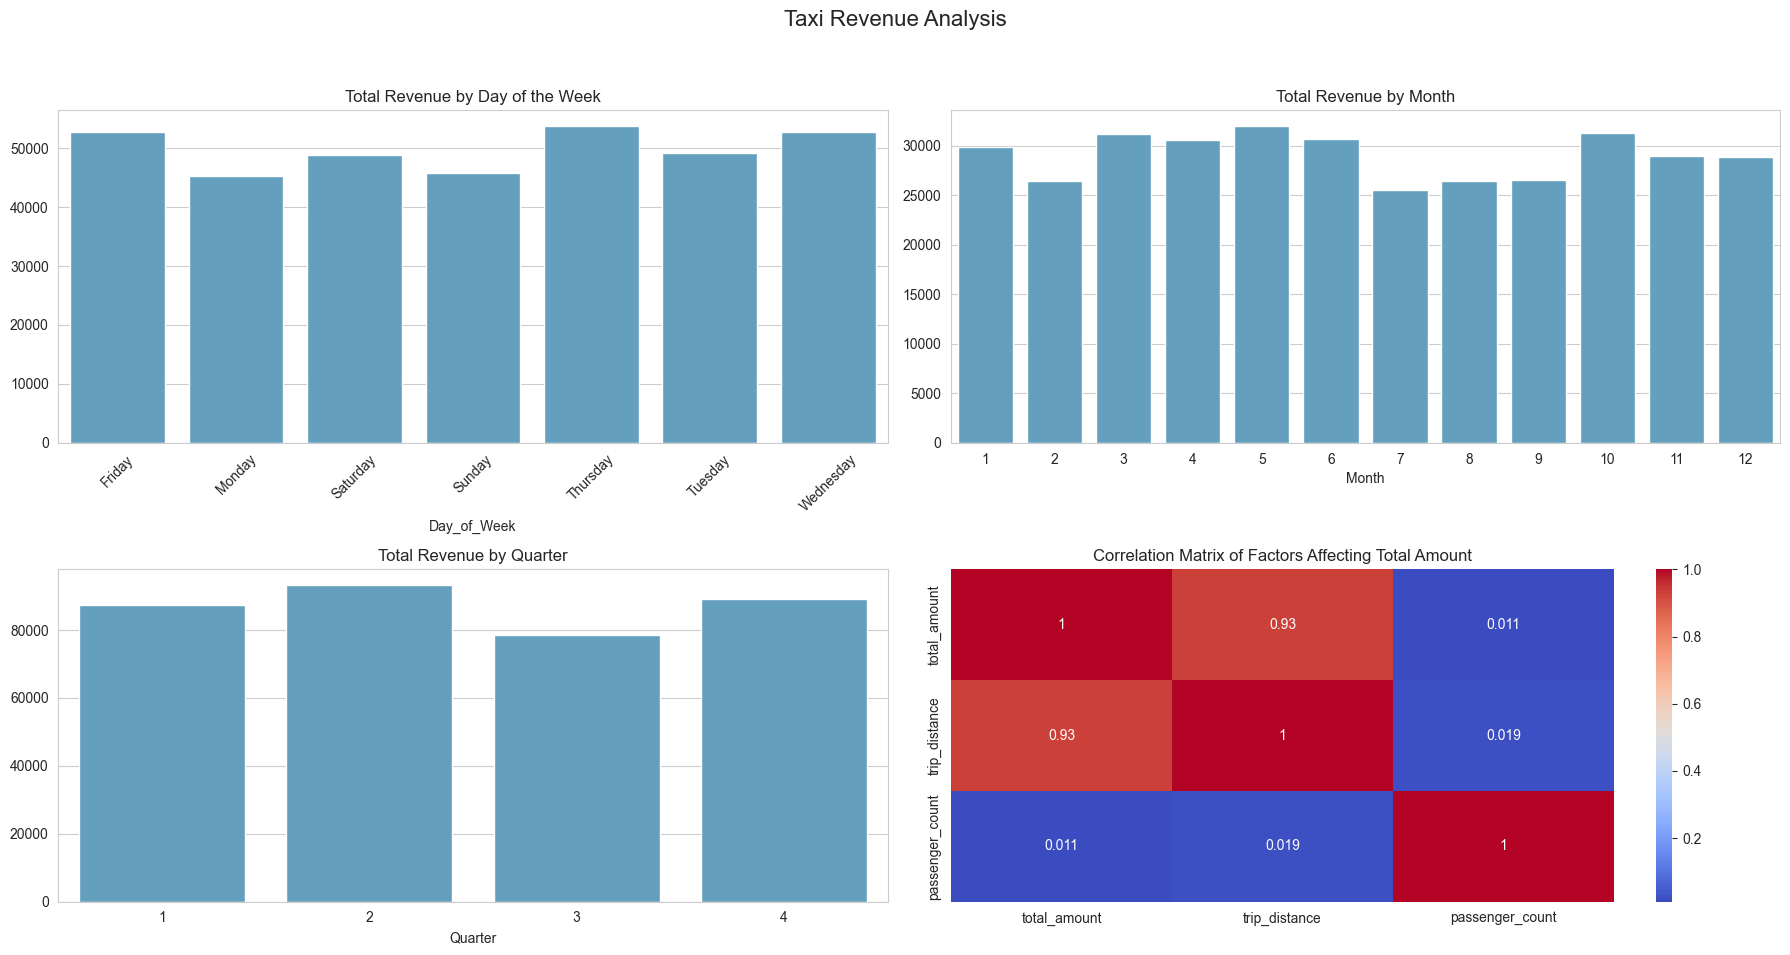

Highest Revenue Day of the Week: Thursday with revenue: 53720.8
Highest Revenue Month: 5 with revenue: 31954.170000000002
Highest Revenue Quarter: 2 with revenue: 93213.18000000001


In [497]:
def analyze_taxi_revenue(df):
    # Convert and extract datetime information
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['Day_of_Week'] = df['tpep_pickup_datetime'].dt.day_name()
    df['Month'] = df['tpep_pickup_datetime'].dt.month
    df['Quarter'] = df['tpep_pickup_datetime'].dt.quarter
    
    # Aggregating revenue data
    daily_revenue = df.groupby('Day_of_Week')['total_amount'].sum().sort_index()
    monthly_revenue = df.groupby('Month')['total_amount'].sum().sort_index()
    quarterly_revenue = df.groupby('Quarter')['total_amount'].sum().sort_index()

    # Setting up the plot area
    plt.figure(figsize=(18, 10))
    plt.suptitle('Taxi Revenue Analysis', fontsize=16)

    # Daily revenue
    plt.subplot(2, 2, 1)
    sns.barplot(x=daily_revenue.index, y=daily_revenue.values)
    plt.title('Total Revenue by Day of the Week')
    plt.xticks(rotation=45)

    # Monthly revenue
    plt.subplot(2, 2, 2)
    sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values)
    plt.title('Total Revenue by Month')

    # Quarterly revenue
    plt.subplot(2, 2, 3)
    sns.barplot(x=quarterly_revenue.index, y=quarterly_revenue.values)
    plt.title('Total Revenue by Quarter')

    # Correlation matrix
    plt.subplot(2, 2, 4)
    correlation_matrix = df[['total_amount', 'trip_distance', 'passenger_count']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Factors Affecting Total Amount')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Output summary of findings
    print("Highest Revenue Day of the Week:", daily_revenue.idxmax(), "with revenue:", daily_revenue.max())
    print("Highest Revenue Month:", monthly_revenue.idxmax(), "with revenue:", monthly_revenue.max())
    print("Highest Revenue Quarter:", quarterly_revenue.idxmax(), "with revenue:", quarterly_revenue.max())


analyze_taxi_revenue(data.copy())

## [5. Model Building]()

Another possible solution is to use machine learning algorithms to create predictive models based on taxi data, to identify taxi fares. Thus, the availability of machine-learning-based predictive tools enables us to take a more targeted and efficient approach to estimate revenue, thereby helping taxi companies optimize their operations and improve their bottom line.  
### Regression Algorithms for Taxi Fare Prediction

#### 1. Linear Regression:
Simple and effective, linear regression models the relationship between input features and fare amounts with a linear equation.

#### 2. Multiple Linear Regression:
Extending linear regression, multiple linear regression considers multiple input features to predict fare amounts accurately.

#### 3. Ridge Regression:
A regularization technique that adds a penalty term to prevent overfitting by penalizing large coefficients.

#### 4. Lasso Regression:
Another regularization technique, Lasso regression promotes sparsity by penalizing the absolute values of coefficients.

#### 5. Elastic Net Regression:
Combining the penalties of Ridge and Lasso regression, Elastic Net handles both L1 and L2 regularization.

### Evaluation Metrics:
- **Mean Absolute Error (MAE)**: Average absolute differences between predicted and actual fare amounts.
- **Mean Squared Error (MSE)**: Average squared differences between predicted and actual fare amounts.
- **Root Mean Squared Error (RMSE)**: Square root of MSE, indicating the average magnitude of errors.
- **R-squared (R2)**: Proportion of variance in fare amounts predictable from input features.

By leveraging these regression algorithms and evaluation metrics, taxi companies can accurately predict fare amounts and optimize pricing strategies.


### [5.1 Feature Engineering](#5.1-Feature-Engineering)

In [498]:
ml = data.copy()
seed=1
ml

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,duration,total_amount
0,VeriFone Inc,2017-03-25 08:55:00,2017-03-25 09:09:00,6,3.34,Standard rate,Not a store and forward trip,100,231,Credit Card,13.0,0.0,0.5,2.76,0.00,0.3,14.0,16.56
1,Creative Mobile Technologies,2017-04-11 14:53:00,2017-04-11 15:19:00,1,1.80,Standard rate,Not a store and forward trip,186,43,Credit Card,16.0,0.0,0.5,4.00,0.00,0.3,26.0,20.80
2,Creative Mobile Technologies,2017-12-15 07:26:00,2017-12-15 07:34:00,1,1.00,Standard rate,Not a store and forward trip,262,236,Credit Card,6.5,0.0,0.5,1.45,0.00,0.3,8.0,8.75
3,VeriFone Inc,2017-05-07 13:17:00,2017-05-07 13:48:00,1,3.70,Standard rate,Not a store and forward trip,188,97,Credit Card,20.5,0.0,0.5,6.39,0.00,0.3,31.0,27.69
4,VeriFone Inc,2017-04-15 23:32:00,2017-04-15 23:49:00,1,4.37,Standard rate,Not a store and forward trip,4,112,Cash,16.5,0.5,0.5,0.00,0.00,0.3,17.0,17.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22694,VeriFone Inc,2017-02-24 17:37:00,2017-02-24 17:40:00,3,0.61,Standard rate,Not a store and forward trip,48,186,Cash,4.0,1.0,0.5,0.00,0.00,0.3,3.0,5.80
22695,VeriFone Inc,2017-08-06 16:43:00,2017-08-06 17:24:00,1,9.27,JFK,Not a store and forward trip,132,164,Credit Card,38.5,0.0,0.5,14.64,5.76,0.3,41.0,44.95
22696,VeriFone Inc,2017-09-04 14:54:00,2017-09-04 14:58:00,1,0.42,Standard rate,Not a store and forward trip,107,234,Cash,4.5,0.0,0.5,0.00,0.00,0.3,4.0,5.30
22697,VeriFone Inc,2017-07-15 12:56:00,2017-07-15 13:08:00,1,2.36,Standard rate,Not a store and forward trip,68,144,Credit Card,10.5,0.0,0.5,1.70,0.00,0.3,12.0,13.00


In [499]:
# ml['year_pickup'] = ml['tpep_pickup_datetime'].dt.year.astype('category')
# ml['year_dropoff'] = ml['tpep_dropoff_datetime'].dt.year.astype('category')
# ml['month_pickup'] = ml['tpep_pickup_datetime'].dt.month_name().astype('category')
# ml['month_dropoff'] = ml['tpep_dropoff_datetime'].dt.month_name().astype('category')

In [500]:
ml.drop(columns=['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID'], inplace=True)

In [501]:
ml.dropna(inplace=True)
ml.isna().sum()

VendorID                 0
passenger_count          0
trip_distance            0
store_and_fwd_flag       0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
duration                 0
total_amount             0
dtype: int64

In [502]:
def split_data(df: pd.DataFrame, test_size: float, random_state: int) -> Tuple[
    pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    x_ = df.drop('total_amount', axis=1)
    y_ = df['total_amount']

    x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=test_size, random_state=random_state)

    return x_, y_, x_train_, x_test_, y_train_, y_test_

In [503]:
# Create pipelines
def create_pipelines(features: pd.DataFrame) -> Dict[str, Pipeline]:
    num_selector = make_column_selector(dtype_include='number')
    cat_selector = make_column_selector(dtype_exclude='number')

    num_cols = num_selector(features)
    cat_cols = cat_selector(features)

    num_preprocessor = StandardScaler()
    cat_preprocessor = OneHotEncoder()

    preprocessor = ColumnTransformer([
        ('StandardScaler', num_preprocessor, num_cols),
        ('OneHotEncoder', cat_preprocessor, cat_cols)
    ])

    return {
        'Linear Regression': make_pipeline(preprocessor, LinearRegression()),
        'Ridge Regression': make_pipeline(preprocessor, Ridge()),
        'Lasso Regression': make_pipeline(preprocessor, Lasso())
    }

### [5.2. Model Training]()

In [504]:
x, y, x_train, x_test, y_train, y_test = split_data(ml.copy(), 0.2, seed)
pipelines = create_pipelines(x)
pipelines['Linear Regression'].fit(x_train, y_train)
y_pred = pipelines['Linear Regression'].predict(x_test)
print("R^2: {}".format(pipelines['Linear Regression'].score(x_test, y_test)))
print("RMSE: {}".format(mean_squared_error(y_test, y_pred, squared=False)))